# Convolve and Match
Given a fragment we can identify its position in the reference sequence by 
convolving the fragment with the reference sequence and finding the position 
where the convolution is maximized. 

In [118]:
import numpy as np
import os 

def load_fragments_arrays(folder_path: str):
    fragments_to_array = {}
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".npy"):
                fragment_number = os.path.basename(root)  # Assuming the folder name represents the fragment number
                fragment_array = np.load(os.path.join(root, file))
                # Average along the first dimension only
                fragment_array = np.mean(fragment_array, axis=0)
                fragments_to_array[fragment_number] = fragment_array
    return fragments_to_array

folder_path = '../data/fragments/'
fragment_arrays = load_fragments_arrays(folder_path)

In [106]:
fragment_arrays["1"].shape

(18, 4)

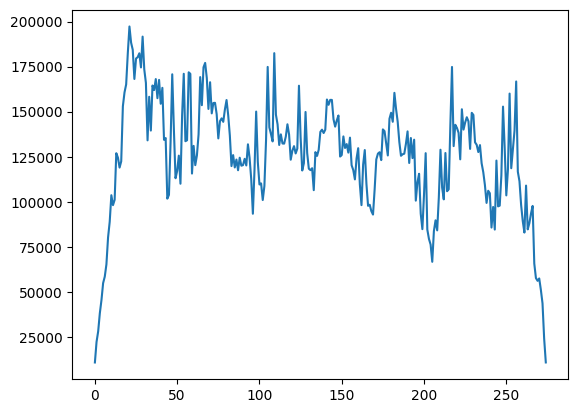

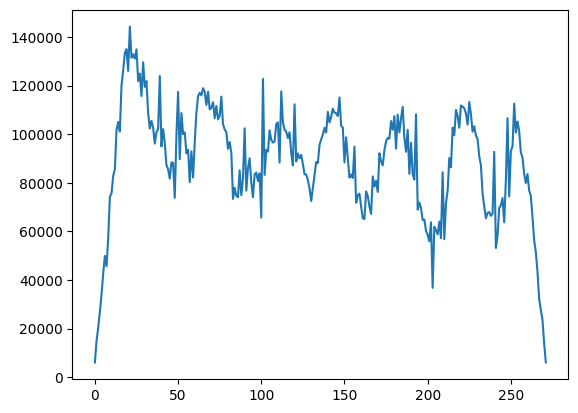

(255, 4)

In [107]:

import ampal
from src.data_processing.create_fragment_angles import calculate_angles_for_structure


sample_structure_path = '../data/pdbs/1A8P.pdb1'
structure = ampal.load_pdb(str(sample_structure_path))[0]

angles = calculate_angles_for_structure(list(structure.get_monomers
                                             (ligands=False   
                                                                    )))
angles = np.array(angles)
# Plot the convolution results
a = np.convolve(fragment_arrays["7"][:, 1],angles[:, 1], mode='full')
import matplotlib.pyplot as plt
plt.plot(a)
plt.show()

# Plot the convolution results
a = np.convolve(fragment_arrays["1"][:, 1],angles[:, 1], mode='full')
import matplotlib.pyplot as plt
plt.plot(a)
plt.show()

angles.shape

# Convolve the angles with the fragment arrays

# Plot the convolution results

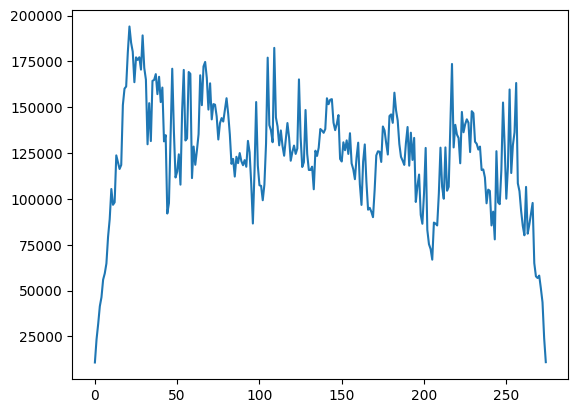

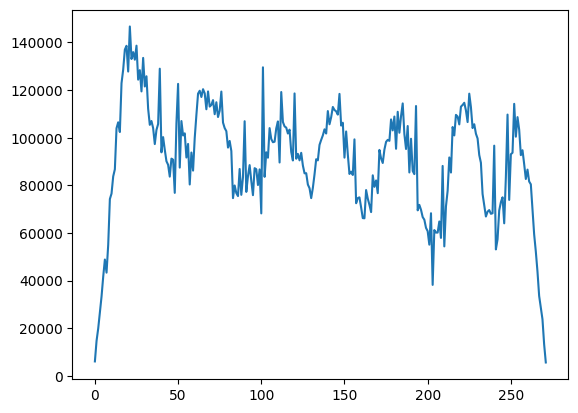

In [4]:
# Plot the convolution results
a = np.convolve(fragment_arrays["7"][:, 1],angles[:, 1], mode='full')
import matplotlib.pyplot as plt
plt.plot(a)
plt.show()

# Plot the convolution results
a = np.convolve(fragment_arrays["1"][:, 1],angles[:, 1], mode='full')
import matplotlib.pyplot as plt
plt.plot(a)
plt.show()



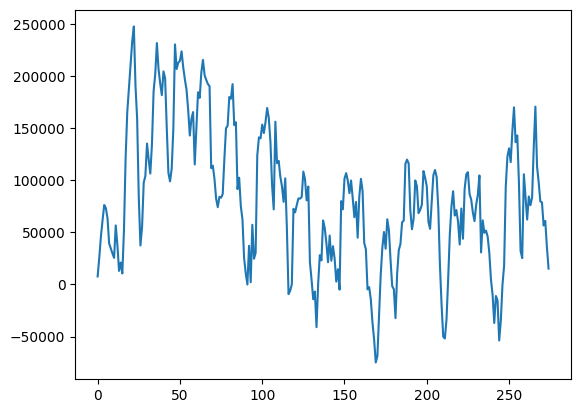

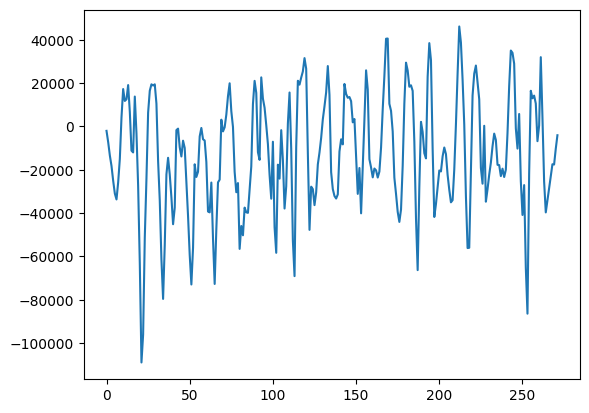

In [5]:
# Plot the convolution results
a = np.convolve(fragment_arrays["7"][:, 2],angles[:, 2], mode='full')
import matplotlib.pyplot as plt
plt.plot(a)
plt.show()

# Plot the convolution results
a = np.convolve(fragment_arrays["1"][:, 2],angles[:, 2], mode='full')
import matplotlib.pyplot as plt
plt.plot(a)
plt.show()



In [6]:
c = np.convolve(angles[:, 3], fragment_arrays["1"][:, 3], mode='full')

# Plot the convolution results
import matplotlib.pyplot as plt
plt.plot(b)
plt.show()


NameError: name 'b' is not defined

In [ ]:
c = np.convolve(angles[:, 0], fragment_arrays["1"][:, 0], mode='same')
# Plot the convolution results
import matplotlib.pyplot as plt
plt.plot(b)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ampal

# Function to perform circular convolution using FFT
def circular_convolution(signal, kernel):
    # Ensure kernel is the same length as signal for FFT-based circular convolution
    if len(signal) != len(kernel):
        # Pad the shorter array with zeros
        if len(signal) > len(kernel):
            kernel = np.pad(kernel, (0, len(signal) - len(kernel)), 'constant')
        else:
            signal = np.pad(signal, (0, len(kernel) - len(signal)), 'constant')
    # Compute Fourier transforms
    signal_fft = np.fft.fft(signal)
    kernel_fft = np.fft.fft(kernel)
    # Perform element-wise multiplication and inverse FFT
    convolved = np.fft.ifft(signal_fft * kernel_fft)
    return np.real(convolved)

# Load structure
sample_structure_path = '../data/pdbs/1A8P.pdb1'
structure = ampal.load_pdb(str(sample_structure_path))[0]
angles = calculate_angles_for_structure(list(structure.get_monomers(ligands=False)))
angles = np.array(angles)

# Assuming fragment_arrays is a dict with fragment IDs as keys and arrays of angles as values
fragment_scores = np.zeros((len(angles), len(fragment_arrays)))

for fragment_id, fragment_angles in fragment_arrays.items():
    if fragment_id.startswith("B"):
        continue  # Skip the background fragment
    # Convert angles to radians for circular convolution
    fragment_angles_rad = np.radians(fragment_angles[:, 1])
    angles_rad = np.radians(angles[:, 1])
    # Perform circular convolution
    conv_result = circular_convolution(angles_rad, fragment_angles_rad)
    # Store the scores
    fragment_scores[:, int(fragment_id)] = conv_result

# Determine the best matching fragment for each position
best_fragments = np.argmax(fragment_scores, axis=1)
best_scores = np.max(fragment_scores, axis=1)

print(best_fragments)


In [7]:
fragment_scores.shape

NameError: name 'fragment_scores' is not defined

In [8]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.signal import convolve2d

def convert_to_sin_cos(angles):
    sin_angles = np.sin(np.radians(angles))
    cos_angles = np.cos(np.radians(angles))
    return sin_angles, cos_angles


# Load structure
sample_structure_path = '../data/pdbs/1A8P.pdb1'
structure = ampal.load_pdb(str(sample_structure_path))[0]
angles = calculate_angles_for_structure(list(structure.get_monomers(ligands=False)))
angles = np.array(angles)

# Assuming `angles` is an array of Phi and Psi angles for the protein structure
# and `fragment_arrays` is a dictionary of Phi and Psi angles for each fragment
sin_phi_structure, cos_phi_structure = convert_to_sin_cos(angles[:, 0])
sin_psi_structure, cos_psi_structure = convert_to_sin_cos(angles[:, 1])

# Prepare structure data for comparison
structure_data = np.stack([sin_phi_structure, cos_phi_structure, sin_psi_structure, cos_psi_structure], axis=1)

best_match = np.zeros(len(angles), dtype=int) - 1  # Initialize with -1 to indicate unmatched positions
best_distance = np.full(len(angles), np.inf)

for fragment_id, frag_angles in fragment_arrays.items():
    if fragment_id.startswith("B"):
        continue  # Skip the background fragment
    # Convert fragment angles to sine and cosine components
    sin_phi_frag, cos_phi_frag = convert_to_sin_cos(frag_angles[:, 0])
    sin_psi_frag, cos_psi_frag = convert_to_sin_cos(frag_angles[:, 1])
    
    # Prepare fragment data for comparison
    fragment_data = np.stack([sin_phi_frag, cos_phi_frag, sin_psi_frag, cos_psi_frag], axis=1)
    
    # Iterate over the structure with a sliding window matching the fragment's length
    for i in range(len(angles) - len(frag_angles) + 1):
        structure_segment = structure_data[i:i+len(frag_angles)]
        
        # Compute cosine distance for each component and sum them
        total_distance = sum(cosine(structure_segment[:, j], fragment_data[:, j]) for j in range(structure_segment.shape[1]))
        
        # Update the best match and distance if this fragment is a better match
        if total_distance < best_distance[i]:
            best_distance[i] = total_distance
            best_match[i] = int(fragment_id)

# Now `best_match` contains the ID of the best matching fragment for each position


In [9]:
print(best_match)

[25 20 23 17 25 25 23 25 25 25 15 40 34 34 25 25 37  7 25 25 25  7 17 17
 17 23 25 15 25 20 34 23 25 34 25 33 15 25 33 40 10 33  1 35 35 12 23 23
 15 25 17 23 23 17 26 23 34 34 33 33 34 34 16 16 40 37 18  1  7 17 17 17
 35 23 17 17 17 35 17 26 17 24 35 17 15 33 35 20 10 16 40 23 34 25 23  3
 23 23 23 34  2 16 34 33 33 34 26 16 33 37 33 33  1  1 17  2 17 40 23 17
 17 25 17 15 23 17 17 17 17 17 34 16 24 33 10 33 34 34 34 34 33 16 33 28
 28 24 24 24 17  1 17 17  2 17 32  1 17 17 35 18 24 23 23 17 17 17 17 17
 17 39 24 34 20 33 34  2 16 34 40 34 40 16 33  1 24 17  1 17 17 17  1 17
 35  2 23 35 17 23 17 23 23 28 17 17 34 17 34 34 34 34 40 34 16 37 33 37
 33 32  1 17  1 17 17 17 17 17 17 17 17  7 17 23 17 23 23 23 17 15 40 23
 25 20 15 17 17 17 17 17 17 -1 -1 -1 -1 -1 -1]


In [10]:
import numpy as np
from scipy.spatial.distance import cosine

# Function to convert angles to sine and cosine components
def convert_to_sin_cos(angles):
    sin_angles = np.sin(np.radians(angles))
    cos_angles = np.cos(np.radians(angles))
    return sin_angles, cos_angles

# Load structure
sample_structure_path = '../data/pdbs/1A8P.pdb1'
structure = ampal.load_pdb(str(sample_structure_path))[0]
angles = calculate_angles_for_structure(list(structure.get_monomers(ligands=False)))
structure_angles = np.array(angles)

# Convert the structure angles to sine and cosine components
sin_phi_structure, cos_phi_structure = (convert_to_sin_cos
                                        (structure_angles[:, 1]))
sin_psi_structure, cos_psi_structure = (convert_to_sin_cos
                                        (structure_angles[:, 2]))
structure_components = np.stack([sin_phi_structure, cos_phi_structure, sin_psi_structure, cos_psi_structure], axis=1)

# Placeholder for classification results
classification_results = []

# Sliding window size (10-15 amino acids)
window_size = 5

# Assuming fragment_arrays is populated with your fragments
for fragment_id, frag_angles in fragment_arrays.items():
    if fragment_id.startswith("B"):
        continue  # Skip the background fragment
    # Convert fragment angles to sine and cosine components
    sin_phi_frag, cos_phi_frag = convert_to_sin_cos(frag_angles[:, 1])
    sin_psi_frag, cos_psi_frag = convert_to_sin_cos(frag_angles[:, 2])
    fragment_components = np.stack([sin_phi_frag, cos_phi_frag, sin_psi_frag, cos_psi_frag], axis=1)
    
    best_distance = np.inf
    best_start_pos = None
    
    # Slide over the protein structure
    for start_pos in range(len(structure_angles) - window_size + 1):
        end_pos = start_pos + window_size
        structure_window = structure_components[start_pos:end_pos]
        
        # Calculate cosine distance for the window
        distance = 0
        for i in range(window_size):
            for j in range(4):  # 4 components: sin_phi, cos_phi, sin_psi, cos_psi
                distance += cosine(structure_window[i, j], fragment_components[i % len(frag_angles), j])
        
        # Update best match if current window is a better match
        if distance < best_distance:
            best_distance = distance
            best_start_pos = start_pos
    
    # Save classification result for the fragment with the best match
    if best_start_pos is not None:
        classification_results.append((fragment_id, best_start_pos, best_start_pos + window_size, best_distance))

# Sort results by start position
classification_results.sort(key=lambda x: x[1])

# Print or process classification results
for result in classification_results:
    print(f"Fragment {result[0]} best matches between positions {result[1]} and {result[2]} with distance {result[3]}")


Fragment 15 best matches between positions 3 and 8 with distance 2.0
Fragment 13 best matches between positions 6 and 11 with distance 2.0
Fragment 16 best matches between positions 16 and 21 with distance 4.440892098500626e-16
Fragment 25 best matches between positions 17 and 22 with distance 5.551115123125783e-16
Fragment 33 best matches between positions 18 and 23 with distance 6.661338147750939e-16
Fragment 12 best matches between positions 18 and 23 with distance 4.0
Fragment 40 best matches between positions 24 and 29 with distance 8.0
Fragment 26 best matches between positions 28 and 33 with distance 2.000000000000001
Fragment 10 best matches between positions 40 and 45 with distance 4.0
Fragment 20 best matches between positions 55 and 60 with distance 8.0
Fragment 34 best matches between positions 84 and 89 with distance 4.440892098500626e-16
Fragment 8 best matches between positions 106 and 111 with distance 3.3306690738754696e-16
Fragment 37 best matches between positions 10

In [11]:
import numpy as np

def convert_to_sin_cos(angles):
    return np.sin(np.radians(angles)), np.cos(np.radians(angles))

def calculate_distance_metric(structure_window, fragment_components):
    # Using Euclidean distance and normalizing to [0, 1] range
    distance = np.sqrt(np.sum((structure_window - fragment_components) ** 2))
    # Normalize: Assuming max possible distance is sqrt(4*window_size) for 4 components each max diff sqrt(1)
    normalized_distance = distance / np.sqrt(4 * len(structure_window))
    return 1 - normalized_distance  # Invert to match the requirement: 1 (identical) - 0 (dissimilar)

def find_best_match_for_fragment(structure_components, fragment_components, fragment_id):
    window_size = len(fragment_components)
    best_score = -np.inf  # Initialize with the lowest possible score
    best_start_pos = None

    for start_pos in range(len(structure_components) - window_size + 1):
        structure_window = structure_components[start_pos:start_pos + window_size]
        score = calculate_distance_metric(structure_window.flatten(), fragment_components.flatten())
        
        if score > best_score:
            best_score = score
            best_start_pos = start_pos

    return best_start_pos, best_score

# Main execution
structure = ampal.load_pdb(str(sample_structure_path))[0]
angles = calculate_angles_for_structure(list(structure.get_monomers(ligands=False)))
structure_angles = np.array(angles)
sin_phi_structure, cos_phi_structure = convert_to_sin_cos(structure_angles[:, 0])
sin_psi_structure, cos_psi_structure = convert_to_sin_cos(structure_angles[:, 1])
structure_components = np.stack([sin_phi_structure, cos_phi_structure, sin_psi_structure, cos_psi_structure], axis=1)

classification_array = np.full(len(structure_angles), -1, dtype=object)  # Initialize classification array

for fragment_id, frag_angles in fragment_arrays.items():
    if fragment_id.startswith("B"): continue  # Skip background fragments
    sin_phi_frag, cos_phi_frag = convert_to_sin_cos(frag_angles[:, 0])
    sin_psi_frag, cos_psi_frag = convert_to_sin_cos(frag_angles[:, 1])
    fragment_components = np.stack([sin_phi_frag, cos_phi_frag, sin_psi_frag, cos_psi_frag], axis=1)

    best_start_pos, best_score = find_best_match_for_fragment(structure_components, fragment_components, fragment_id)
    
    if best_start_pos is not None:
        # Fill classification array for the matched segment
        classification_array[best_start_pos:best_start_pos+len(frag_angles)] = fragment_id

# classification_array now contains the best matching fragment ID for each amino acid position


In [12]:
print(classification_array)

[-1 -1 -1 '20' '20' '20' '20' '20' '20' '20' '20' '20' '20' '20' '20' '20'
 -1 -1 -1 -1 -1 '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12'
 '12' '12' '12' '12' '12' -1 -1 -1 '10' '10' '10' '10' '10' '10' '10' '10'
 '10' '10' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22'
 '22' '25' '25' '25' '25' '25' '25' '25' '25' '25' '25' '25' '25' '25'
 '25' '25' '22' '22' '22' '22' '22' '36' '36' '36' '36' '36' '29' '29'
 '29' '29' '29' '29' '11' '11' -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 '8'
 '37' '37' '37' '37' '37' '37' '37' '37' '37' '39' '39' '39' '39' '39'
 '39' '39' '39' '39' '39' '39' '39' '39' '39' '39' '39' '39' '39' '39'
 '39' '24' '24' '24' '24' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5'
 '5' '5' '5' '5' '38' '38' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9'
 '9' '26' '26' '26' '26' '26' '26' '26' '26' '26' '26' '26' '26' '26' '26'
 -1 -1 -1 -1 '34' '34' '34' '16' '16' '16' '16' '16' '16

In [13]:
import numpy as np

def angular_difference(angle1, angle2):
    """Calculate the smallest angular difference (in radians)"""
    diff = np.abs(angle1 - angle2) % (2 * np.pi)
    return np.where(diff > np.pi, 2 * np.pi - diff, diff)

def calculate_angular_similarity(structure_window, fragment_components):
    """Calculate angular similarity between structure window and fragment"""
    # Assuming structure_window and fragment_components are already in radians
    avg_diff = np.mean(angular_difference(structure_window, fragment_components))
    # Normalize the average difference to a [0, 1] range, assuming max diff is pi
    similarity = 1 - (avg_diff / np.pi)
    return similarity

# Assuming other functions and data loading as previously defined

classification_array = np.full(len(structure_angles), -1, dtype=object)  # Initialize classification array

for fragment_id, frag_angles in fragment_arrays.items():
    if fragment_id.startswith("B"): continue  # Skip background fragments

    # Prepare fragment components (no need to convert to sin/cos, use radians directly)
    frag_phi, frag_psi = frag_angles[:, 1], frag_angles[:, 2]
    fragment_size = len(frag_angles)
    
    best_similarity = -np.inf  # Initialize with the lowest possible similarity
    best_start_pos = None
    
    for start_pos in range(len(structure_angles) - fragment_size + 1):
        # Extract the corresponding window of phi and psi angles in radians
        window_phi = structure_angles[start_pos:start_pos + fragment_size, 1]
        window_psi = structure_angles[start_pos:start_pos + fragment_size, 2]
        
        # Calculate angular similarity for both Phi and Psi
        similarity_phi = calculate_angular_similarity(window_phi, frag_phi)
        similarity_psi = calculate_angular_similarity(window_psi, frag_psi)
        average_similarity = (similarity_phi + similarity_psi) / 2
        
        if average_similarity > best_similarity:
            best_similarity = average_similarity
            best_start_pos = start_pos
    
    if best_start_pos is not None:
        classification_array[best_start_pos:best_start_pos+fragment_size] = fragment_id

# classification_array now contains the best matching fragment ID for each amino acid position


In [14]:
print(classification_array)

[-1 -1 -1 -1 -1 '27' '27' '27' '25' '25' '25' '25' '25' '25' '25' '25'
 '25' '25' '25' '25' '25' '25' '25' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '38' '38' '38' '38' '38' '38' '38' '38' '38'
 '38' '38' '38' '38' '38' '38' '38' '38' -1 -1 '28' '26' '26' '3' '3' '3'
 '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3'
 '3' '3' '3' '3' '3' '3' '10' '10' '10' '10' '10' '10' '10' '10' '10' '10'
 '10' '10' '12' '12' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '31' '31' '31' '31' '31' '31'
 '31' '31' '31' '31' '31' '31' '31' '39' '39' '39' '39' '39' '39' '24'
 '24' '24' '24' '14' '14' '14' '14' '14' '14' '14' '14' '14' '14' '14'
 '14' '14' '14' '14' '14' '14' '14' '14' '14' '14' '21' '21' '21' '21'
 '21' '21' '21' '21' '21' '21' '29' '29' '17' '17' '17' '17' '17' '17'
 '17' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22

In [15]:
structure_angles.shape

(255, 4)

In [16]:
import numpy as np

def convert_to_radians(angles):
    """Convert angles from degrees to radians."""
    return np.radians(angles)

def angular_similarity(angle1, angle2):
    """Calculate similarity based on angular difference, normalized to [0, 1] range."""
    diff = np.abs(np.arctan2(np.sin(angle1 - angle2), np.cos(angle1 - angle2)))
    similarity = 1 - (diff / np.pi)  # Normalizing the difference to a [0, 1] similarity measure
    return similarity

def find_best_matching_fragment(structure_angles, fragment_angles):
    """Find the best matching fragment for each position in the protein structure."""
    n_amino_acids = len(structure_angles)
    classification_array = np.full(n_amino_acids, -1, dtype=object)  # Initialize with -1 for unclassified positions

    for fragment_id, frag_angles in fragment_arrays.items():
        frag_phi, frag_psi = convert_to_radians(frag_angles[:, 1]), convert_to_radians(frag_angles[:, 2])
        fragment_size = len(frag_angles)
        best_similarity = -np.inf
        best_start_pos = None

        for start_pos in range(n_amino_acids - fragment_size + 1):
            window_phi = structure_angles[start_pos:start_pos + fragment_size, 1]
            window_psi = structure_angles[start_pos:start_pos + fragment_size, 2]
            similarity_phi = angular_similarity(window_phi, frag_phi)
            similarity_psi = angular_similarity(window_psi, frag_psi)
            average_similarity = np.mean([similarity_phi, similarity_psi])

            if average_similarity > best_similarity:
                best_similarity = average_similarity
                best_start_pos = start_pos

        # Update the classification array with the fragment ID for the best matching segment
        if best_start_pos is not None:
            classification_array[best_start_pos:best_start_pos+fragment_size] = fragment_id

    return classification_array

# Assuming the structure_angles and fragment_arrays are loaded as described
structure = ampal.load_pdb(str(sample_structure_path))[0]
angles = calculate_angles_for_structure(list(structure.get_monomers(ligands=False)))
structure_angles = np.array(angles)
structure_angles[:, 1:3] = convert_to_radians(structure_angles[:, 1:3])  # Convert Phi and Psi to radians

# Find the best matching fragment for each amino acid position
classification_array = find_best_matching_fragment(structure_angles, fragment_arrays)


In [17]:
print(classification_array)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 'B1' 'B1' 'B1' 'B1' 'B1' 'B1' 'B1' 'B1' 'B1'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12'
 '12' -1 -1 -1 -1 -1 -1 -1 '7' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7'
 '7' '7' '7' '7' '7' '7' '7' '7' '7' -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 '9' '37' '37' '37' '37' '37' '37' '37' '37' '37'
 '37' '37' '37' '37' '9' '9' '9' '19' '22' '22' '22' '22' '22' '22' '22'
 '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22'
 '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '5' '5' '5'
 '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '39' '39' '28' '6' -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 '32' '35' '35' '35' '35' '35' '35' '35' '35' '35'
 '35' '35' '35' '35' '35' '25' '25' '25' '25' '25' '25' '25' '25' '25'
 '25' '25' '25' '25' '25' '25' '14' '14' '14' '14' '14' '14'

In [18]:
np.where(classification_array == '7')

(array([68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88]),)

In [19]:
import numpy as np

def convert_to_radians(angles):
    """Convert angles from degrees to radians."""
    return np.radians(angles)

def angular_similarity(angle1, angle2):
    """Calculate angular similarity as the cosine of the difference, normalized to [0, 1]."""
    # Calculate the difference and use cosine to get similarity
    cos_similarity = np.cos(angle1 - angle2)
    # Cosine values range from -1 to 1; normalize to [0, 1]
    normalized_similarity = (cos_similarity + 1) / 2
    return normalized_similarity

def find_best_matching_fragment(structure_angles, fragment_arrays):
    """Find the best matching fragment for each position in the protein structure."""
    n_amino_acids = structure_angles.shape[0]
    classification_array = np.full(n_amino_acids, -1, dtype=object)  # Initialize with -1 for unclassified positions

    # Convert structure angles to radians
    struct_phi, struct_psi = convert_to_radians(structure_angles[:, 1]), convert_to_radians(structure_angles[:, 2])

    for fragment_id, frag_angles in fragment_arrays.items():
        # Convert fragment angles to radians
        frag_phi, frag_psi = convert_to_radians(frag_angles[:, 1]), convert_to_radians(frag_angles[:, 2])
        fragment_size = frag_angles.shape[0]
        
        for start_pos in range(n_amino_acids - fragment_size + 1):
            # Extract the corresponding window of phi and psi angles from the structure
            window_phi = struct_phi[start_pos:start_pos + fragment_size]
            window_psi = struct_psi[start_pos:start_pos + fragment_size]
            
            # Calculate angular similarity for both phi and psi
            similarity_phi = angular_similarity(window_phi, frag_phi).mean()
            similarity_psi = angular_similarity(window_psi, frag_psi).mean()
            average_similarity = (similarity_phi + similarity_psi) / 2

            # Update classification based on similarity
            if classification_array[start_pos] == -1 or average_similarity > classification_array[start_pos][1]:
                classification_array[start_pos:start_pos+fragment_size] = (fragment_id, average_similarity)

    return classification_array

# Assuming structure_angles and fragment_arrays are already defined and loaded as described
classification_array = find_best_matching_fragment(structure_angles, fragment_arrays)


ValueError: could not broadcast input array from shape (2,) into shape (28,)

In [58]:
import numpy as np
from scipy.signal import correlate

def convert_to_sin_cos(angles):
    """Convert angles to their sine and cosine components."""
    return np.sin(np.radians(angles)), np.cos(np.radians(angles))

def find_best_matching_fragment(structure_components, fragment_arrays):
    n_amino_acids = structure_components.shape[1]  # Corrected to use the second dimension
    
    # Initialize arrays to hold the best match score and ID for each position
    best_match_scores = np.full(n_amino_acids, -np.inf)  # Initialize with low scores
    classification_array = np.full(n_amino_acids, None, dtype=object)  # Placeholder for fragment ID
    
    for fragment_id, frag_angles in fragment_arrays.items():
        if fragment_id.startswith("B"):
            continue
        # Convert fragment angles to sine and cosine components
        sin_phi_frag, cos_phi_frag = convert_to_sin_cos(frag_angles[:, 1])
        sin_psi_frag, cos_psi_frag = convert_to_sin_cos(frag_angles[:, 2])
        
        # Stack all components for the fragment
        fragment_components = np.vstack((sin_phi_frag, cos_phi_frag, sin_psi_frag, cos_psi_frag)).T  # Transpose for correct shape
        
        # Initialize an array for summed correlation scores for this fragment
        summed_correlation = np.zeros(n_amino_acids)
        
        # Perform correlation for each component and sum the results
        for i in range(0,4):  # Iterate over the components: sin_phi, 
            # cos_phi, sin_psi, cos_psi
            component_correlation = correlate(structure_components[i, :], fragment_components[:, i], mode='same', method='auto')
            summed_correlation += component_correlation
        
        # Update the classification based on the highest correlation score
        for i in range(n_amino_acids):
            if summed_correlation[i] > best_match_scores[i]:
                best_match_scores[i] = summed_correlation[i]
                classification_array[i] = fragment_id

    return classification_array



# Load structure
sample_structure_path = '../data/pdbs/1A8P.pdb1'
structure = ampal.load_pdb(str(sample_structure_path))[0]
angles = calculate_angles_for_structure(list(structure.get_monomers(ligands=False)))
structure_angles = np.array(angles)
# Convert the structure angles to sine and cosine components
sin_phi_structure, cos_phi_structure = convert_to_sin_cos(structure_angles[:, 1])
sin_psi_structure, cos_psi_structure = convert_to_sin_cos(structure_angles[:, 2])
structure_components = np.stack([sin_phi_structure, cos_phi_structure, sin_psi_structure, cos_psi_structure], axis=0)

classification = find_best_matching_fragment(structure_components, fragment_arrays)


In [54]:
print(classification)

['35' '19' '10' '35' '35' '35' '13' '13' '13' '11' '36' '36' '13' '13'
 '13' '13' '13' '13' '35' '19' '13' '13' '13' '13' '13' '13' '13' '10'
 '36' '36' '13' '7' '13' '13' '13' '13' '13' '19' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '10' '13' '13'
 '13' '13' '7' '13' '13' '13' '22' '13' '13' '11' '13' '33' '33' '33' '34'
 '36' '36' '8' '8' '8' '8' '7' '35' '32' '35' '35' '35' '35' '35' '35'
 '22' '22' '22' '13' '13' '13' '19' '36' '13' '13' '8' '13' '13' '13' '19'
 '19' '19' '22' '22' '19' '13' '13' '30' '22' '22' '22' '22' '22' '22'
 '16' '34' '34' '34' '34' '34' '39' '32' '31' '32' '32' '32' '32' '32'
 '32' '27' '27' '27' '27' '22' '22' '22' '22' '22' '22' '22' '22' '22'
 '22' '22' '22' '34' '34' '22' '22' '22' '39' '39' '39' '39' '39' '39'
 '39' '39' '28' '39' '32' '22' '32' '28' '27' '27' '32' '32' '27' '35'
 '35' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22'
 '22' '22' '22' '33' '16' '34' '34' '34' '8' '8' '36' '36' '27' '

In [50]:
np.where(classification == '7')

(array([], dtype=int64),)

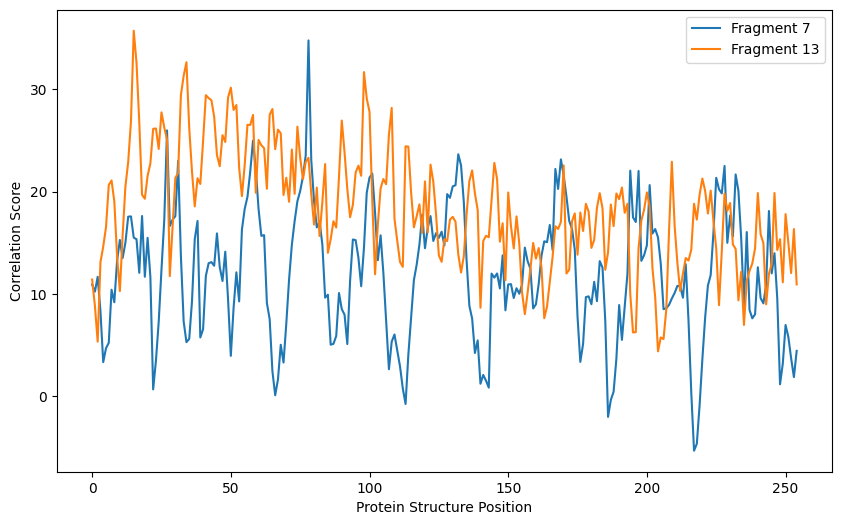

In [62]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

def calculate_correlation_scores(structure_components, fragment_components):
    """Calculate correlation scores for a fragment over the entire protein structure."""
    correlation_scores = np.zeros(structure_components.shape[1])
    for i in range(4):  # For each component: sin_phi, cos_phi, sin_psi, cos_psi
        correlation_scores += correlate(structure_components[i, :], fragment_components[i, :], mode='same', method='auto')
    return correlation_scores

def classify_protein_structure(structure_components, fragment_arrays):
    n_amino_acids = structure_components.shape[1]
    classification_array = np.full(n_amino_acids, None, dtype=object)  # Initialize with placeholder for no match
    correlation_dict = {}  # To store correlation scores for visualization

    for fragment_id, frag_angles in fragment_arrays.items():
        if fragment_id.startswith("B"):
            continue  # Skip the background fragment
        # Convert fragment angles to sine and cosine components
        sin_phi_frag, cos_phi_frag = convert_to_sin_cos(frag_angles[:, 1])
        sin_psi_frag, cos_psi_frag = convert_to_sin_cos(frag_angles[:, 2])
        fragment_components = np.vstack((sin_phi_frag, cos_phi_frag, sin_psi_frag, cos_psi_frag)).T

        # Calculate correlation scores for this fragment across the protein structure
        correlation_scores = np.zeros(n_amino_acids)
        for i in range(4):  # Iterate over the components: sin_phi, cos_phi, sin_psi, cos_psi
            component_correlation = correlate(structure_components[i, :], fragment_components[:, i], mode='same', method='auto')
            correlation_scores += component_correlation
        correlation_dict[fragment_id] = correlation_scores

    # Classification based on the highest correlation score at each position
    for i in range(n_amino_acids):
        highest_score = -np.inf
        best_fragment_id = None
        for fragment_id, scores in correlation_dict.items():
            if scores[i] > highest_score:
                highest_score = scores[i]
                best_fragment_id = fragment_id
        classification_array[i] = best_fragment_id

    return classification_array, correlation_dict


def visualize_correlation_scores(correlation_dict, fragment_ids):
    """Visualize correlation scores for selected fragments."""
    plt.figure(figsize=(10, 6))
    for fragment_id in fragment_ids:
        if fragment_id in correlation_dict:
            plt.plot(correlation_dict[fragment_id], label=f'Fragment {fragment_id}')
    plt.xlabel('Protein Structure Position')
    plt.ylabel('Correlation Score')
    plt.legend()
    plt.show()

# Assuming structure_components and fragment_arrays are defined as before
classification_array, correlation_dict = classify_protein_structure(structure_components, fragment_arrays)

# Visualize correlation scores for a set of fragments
visualize_correlation_scores(correlation_dict, ['7', '13'])  # Example 
# fragment IDs


In [63]:
print(classification_array)

['35' '19' '10' '35' '35' '35' '13' '13' '13' '11' '36' '36' '13' '13'
 '13' '13' '13' '13' '35' '19' '13' '13' '13' '13' '13' '13' '13' '10'
 '36' '36' '13' '7' '13' '13' '13' '13' '13' '19' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '10' '13' '13'
 '13' '13' '7' '13' '13' '13' '22' '13' '13' '11' '13' '33' '33' '33' '34'
 '36' '36' '8' '8' '8' '8' '7' '35' '32' '35' '35' '35' '35' '35' '35'
 '22' '22' '22' '13' '13' '13' '19' '36' '13' '13' '8' '13' '13' '13' '19'
 '19' '19' '22' '22' '19' '13' '13' '30' '22' '22' '22' '22' '22' '22'
 '16' '34' '34' '34' '34' '34' '39' '32' '31' '32' '32' '32' '32' '32'
 '32' '27' '27' '27' '27' '22' '22' '22' '22' '22' '22' '22' '22' '22'
 '22' '22' '22' '34' '34' '22' '22' '22' '39' '39' '39' '39' '39' '39'
 '39' '39' '28' '39' '32' '22' '32' '28' '27' '27' '32' '32' '27' '35'
 '35' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22' '22'
 '22' '22' '22' '33' '16' '34' '34' '34' '8' '8' '36' '36' '27' '

In [64]:
from scipy.signal import correlate2d

def calculate_2d_correlation_scores(structure_components, fragment_components):
    """Calculate 2D correlation scores for a fragment over the entire protein structure."""
    # structure_components and fragment_components are both shaped as [4, n_amino_acids]
    # Perform 2D correlation
    correlation_scores = correlate2d(structure_components, fragment_components, mode='same', boundary='wrap')
    return correlation_scores.sum(axis=0)  # Summing across the component dimension for overall scores

def classify_protein_structure_with_smoothing(structure_components, fragment_arrays):
    n_amino_acids = structure_components.shape[1]
    # Initialize arrays to hold the best match score for each position
    best_match_scores = np.full(n_amino_acids, -np.inf)
    classification_array = np.full(n_amino_acids, None, dtype=object)  # Placeholder for fragment ID
    correlation_dict = {}  # To store correlation scores for visualization

    for fragment_id, frag_angles in fragment_arrays.items():
        # Convert fragment angles to sine and cosine components and stack them for 2D correlation
        sin_phi_frag, cos_phi_frag = convert_to_sin_cos(frag_angles[:, 1])
        sin_psi_frag, cos_psi_frag = convert_to_sin_cos(frag_angles[:, 2])
        fragment_components = np.vstack((sin_phi_frag, cos_phi_frag, sin_psi_frag, cos_psi_frag))

        # Calculate 2D correlation scores
        correlation_scores = calculate_2d_correlation_scores(structure_components, fragment_components)
        correlation_dict[fragment_id] = correlation_scores

        # Update classification based on the highest correlation score
        for i in range(n_amino_acids):
            if correlation_scores[i] > best_match_scores[i]:
                best_match_scores[i] = correlation_scores[i]
                classification_array[i] = fragment_id

    return classification_array, correlation_dict

def visualize_correlation_scores(correlation_dict, fragment_ids):
    plt.figure(figsize=(10, 6))
    for fragment_id in fragment_ids:
        if fragment_id in correlation_dict:
            plt.plot(correlation_dict[fragment_id], label=f'Fragment {fragment_id}')
    plt.xlabel('Protein Structure Position')
    plt.ylabel('Correlation Score')
    plt.legend()
    plt.show()


In [65]:
classification_array, correlation_dict = classify_protein_structure_with_smoothing(structure_components, fragment_arrays)

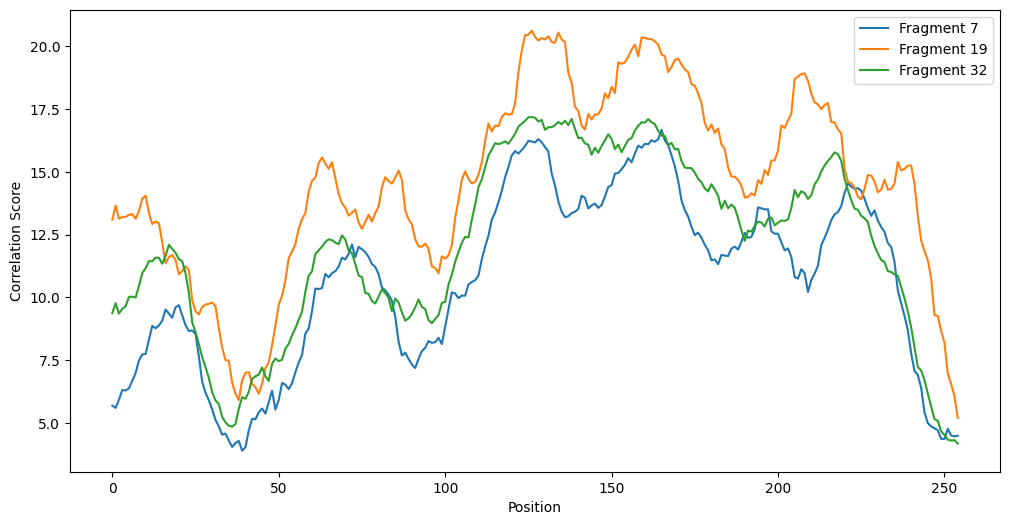

In [113]:
import numpy as np
from scipy.signal import correlate2d

def smooth_classification(correlation_scores, window_size):
    """
    Apply smoothing to select the fragment classification over a window.
    This helps to ensure that fragments span several amino acids coherently.
    """
    smoothed_scores = np.copy(correlation_scores)
    for i in range(len(correlation_scores)):
        start = max(0, i - window_size // 2)
        end = min(len(correlation_scores), i + window_size // 2 + 1)
        smoothed_scores[i] = np.mean(correlation_scores[start:end])
    return smoothed_scores

def classify_protein_structure_with_correlate2d(structure_components, fragment_arrays):
    n_amino_acids = structure_components.shape[1]
    # Initialize array for classification; use dtype=int or another identifier type as needed
    classification_array = np.full(n_amino_acids, -1, dtype=int)
    correlation_dict = {}  # Store correlation results for visualization

    # Assuming structure_components is reshaped if necessary to match (n_features, n_positions)
    for fragment_id, frag_angles in fragment_arrays.items():
        # Prepare fragment for 2D correlation
        sin_phi_frag, cos_phi_frag = convert_to_sin_cos(frag_angles[:, 1])
        sin_psi_frag, cos_psi_frag = convert_to_sin_cos(frag_angles[:, 2])
        fragment_matrix = np.vstack([sin_phi_frag, cos_phi_frag, sin_psi_frag, cos_psi_frag])
        
        # Perform 2D correlation
        correlation_matrix = correlate2d(structure_components, fragment_matrix, mode='same')
        correlation_scores = np.sum(correlation_matrix, axis=0)  # Sum over features axis
        
        # Optional: Smooth the correlation scores for smoother classification
        smoothed_scores = smooth_classification(correlation_scores, 
                                                window_size=15)  # Example 
        # window size
        
        correlation_dict[fragment_id] = smoothed_scores  # Store smoothed scores for visualization
        
        # Update classification based on smoothed correlation scores
        for i in range(n_amino_acids):
            if smoothed_scores[i] > classification_array[i]:
                classification_array[i] = fragment_id  # Update with current fragment ID

    return classification_array, correlation_dict

def visualize_correlation_scores(correlation_dict, fragment_ids):
    plt.figure(figsize=(12, 6))
    for fragment_id in fragment_ids:
        plt.plot(correlation_dict[fragment_id], label=f'Fragment {fragment_id}')
    plt.xlabel('Position')
    plt.ylabel('Correlation Score')
    plt.legend()
    plt.show()

# Example usage
classification_array, correlation_dict = classify_protein_structure_with_correlate2d(structure_components, fragment_arrays)
visualize_correlation_scores(correlation_dict, ['7', '19', '32'])  # Select 
# fragments to visualize


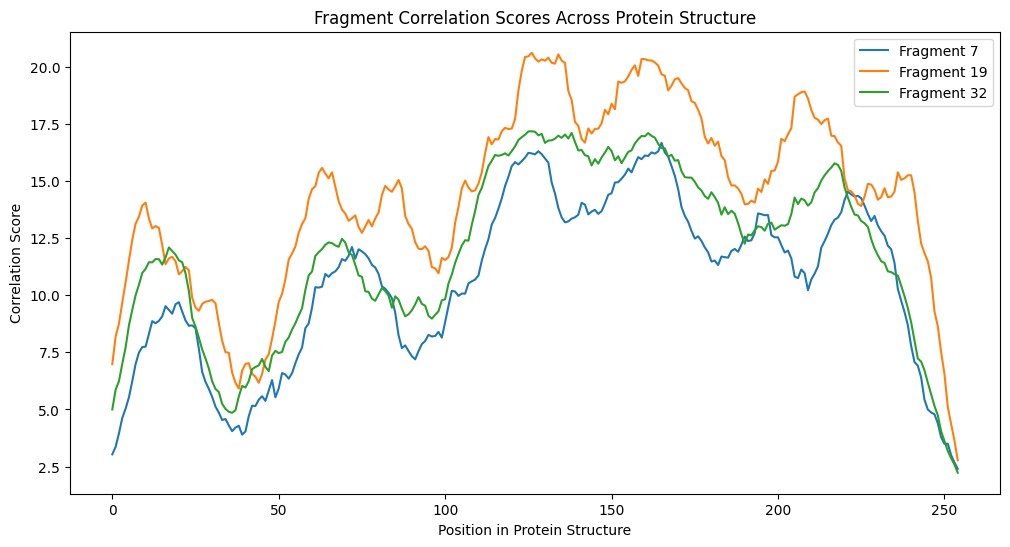

In [114]:
import numpy as np
from scipy.signal import correlate2d
import matplotlib.pyplot as plt

def convert_to_sin_cos(angles):
    """Convert angles to their sine and cosine components."""
    sin_angles = np.sin(np.radians(angles))
    cos_angles = np.cos(np.radians(angles))
    return sin_angles, cos_angles

def smooth_correlation_scores(correlation_scores, window_size=15):
    """Smooth the correlation scores to ensure coherent fragment spans."""
    smoothed_scores = np.convolve(correlation_scores, np.ones(window_size)/window_size, mode='same')
    return smoothed_scores

def classify_protein_structure_with_correlate2d(structure_components, fragment_arrays):
    n_amino_acids = structure_components.shape[1]
    correlation_scores_dict = {}
    classification_array = np.full(n_amino_acids, None, dtype=object)
    max_scores = np.full(n_amino_acids, -np.inf)
    
    for fragment_id, frag_angles in fragment_arrays.items():
        if fragment_id.startswith("B"):
            continue
        sin_phi_frag, cos_phi_frag = convert_to_sin_cos(frag_angles[:, 1])
        sin_psi_frag, cos_psi_frag = convert_to_sin_cos(frag_angles[:, 2])
        fragment_components = np.vstack((sin_phi_frag, cos_phi_frag, sin_psi_frag, cos_psi_frag)).T
        
        correlation_matrix = correlate2d(structure_components.T, fragment_components, mode='same')
        correlation_scores = np.sum(correlation_matrix, axis=1)  # Sum over features axis
        smoothed_scores = smooth_correlation_scores(correlation_scores)
        
        correlation_scores_dict[fragment_id] = smoothed_scores
        
        # Update classification based on the highest smoothed correlation score
        for i in range(n_amino_acids):
            if smoothed_scores[i] > max_scores[i]:
                max_scores[i] = smoothed_scores[i]
                classification_array[i] = fragment_id

    return classification_array, correlation_scores_dict

def visualize_correlation_scores(correlation_scores_dict, fragment_ids):
    """Visualize correlation scores for selected fragments."""
    plt.figure(figsize=(12, 6))
    for fragment_id in fragment_ids:
        if fragment_id in correlation_scores_dict:
            plt.plot(correlation_scores_dict[fragment_id], label=f'Fragment {fragment_id}')
    plt.xlabel('Position in Protein Structure')
    plt.ylabel('Correlation Score')
    plt.legend()
    plt.title('Fragment Correlation Scores Across Protein Structure')
    plt.show()

# Example usage assuming structure_components and fragment_arrays are predefined
# structure_components: [4, n_amino_acids] array from the protein structure
# fragment_arrays: dictionary with fragment IDs as keys and angle arrays as values

classification_array, correlation_scores_dict = classify_protein_structure_with_correlate2d(structure_components, fragment_arrays)

# Visualize correlation scores for a subset of fragments
visualize_correlation_scores(correlation_scores_dict, ['7', '19', '32'])  # 
# Example fragment IDs


In [115]:
print(classification_array)

['13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13' '13'
 '13' 

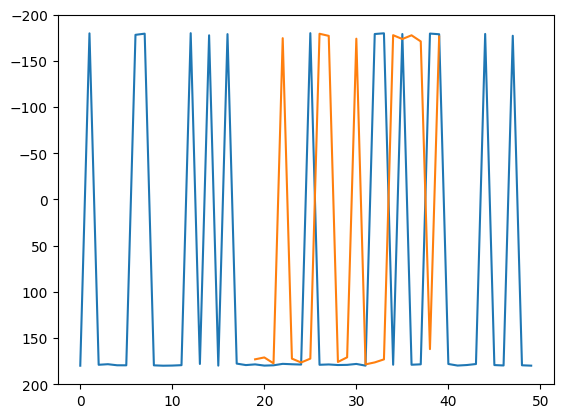

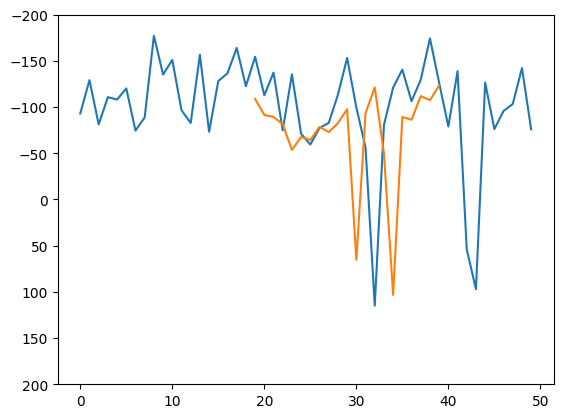

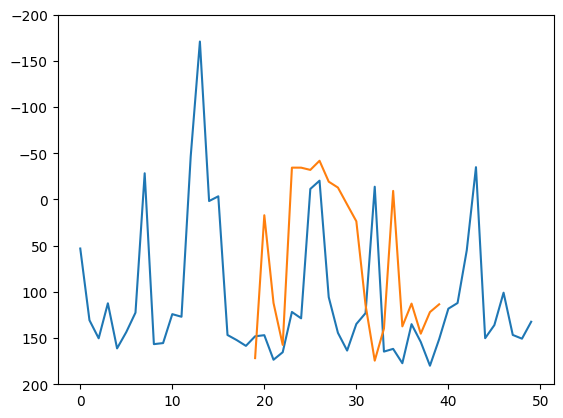

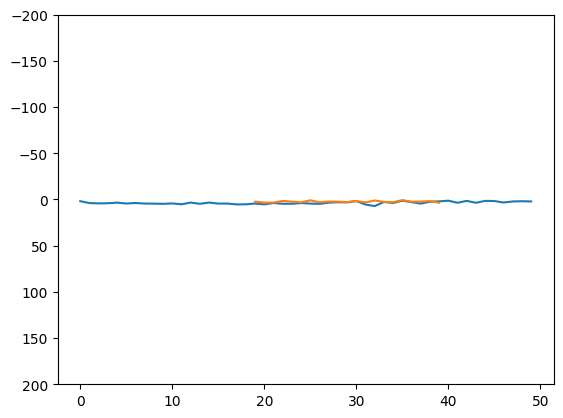

In [116]:
# structure_angles.shape is (255, 4). For each channel, plot position 0 - 50
import matplotlib.pyplot as plt
#plot but ensure y axis limits are between 180 and -180
for i in range(4):
    plt.plot(structure_angles[:50, i])
    # In a different color also plot fragment array 7 for the same range but
    # position it at 19 in the x axis
    plt.plot(np.arange(19, 19 + len(fragment_arrays["7"])), fragment_arrays["7"][:, i])
    plt.ylim(200, -200)
    plt.show()
    

In [117]:
fragment_arrays["7"].shape


(21, 4)